# Predizione Indice Di Borsa: NASDAQ
## Autori: Luca Morlino e Valerio Di Zio


## Descrizione del problema
### Cos'è NASDAQ?
Il Nasdaq Composite è l'indice azionario statunitense che comprende titoli nazionali e internazionali in cui sono quotate più di 5.200 società. È stato creato nel 1971 con una base di 100.
Le società che compongono l'indice seguono i criteri di capitalizzazione. Il Nasdaq è un indice molto volatile dove sono integrate le più importanti società tecnologiche del mondo.

### Obiettivo
L'obiettivo generale è quello di creare un algoritmo che preveda il valore di chiusura del titolo a inizio giornata.

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

## Estrazione dati
I dati relativi a ^IXIC vengono scaricati dal servizio [Yahoo! Finance](https://it.finance.yahoo.com/).
Per fare ciò viene utilizzata la libreria yfinance che permette l'estrazione di dati in forma di oggetti Python facilmente interrogabili.
In particolare, la usiamo per ottenere i dati storici in forma di Dataframe Pandas.

In [129]:
import yfinance

- Creiamo un oggetto Ticker che rappresenta uno specifico titolo o indice
- Nel nostro caso il simbolo del Nasdaq con il suo valore in dollari è ^IXIC

In [130]:
nasdaq = yfinance.Ticker("^IXIC")

- Utilizziamo il metodo history per ottenere i dati storici, partendo dal 2 Gennaio 2011 fino al 31 Dicembre 2021.

In [131]:
data = nasdaq.history(start="2011-01-02", end="2021-12-31", actions=False)

Ad esempio, guardiamo i dati relativi agli ultimi 5 giorni dell'anno 2021. 

In [132]:
data.tail(5)

,Open,High,Low,Close,Volume
Date,,,,,
2021-12-23,15544.790039,15697.980469,15528.910156,15653.370117,3918200000
2021-12-27,15696.830078,15871.400391,15696.830078,15871.259766,3730120000
2021-12-28,15895.200195,15901.469727,15757.070312,15781.719727,3623600000
2021-12-29,15794.919922,15821.809570,15679.849609,15766.219727,3694500000
2021-12-30,15758.980469,15868.089844,15729.160156,15741.559570,3732730000


Andiamo a contare il numero di istanze ricavate

In [133]:
data.shape[0]

2768

## Features
Il nostro dataset, inizialmente, ha 5 features:
- Open: è il valore in dollari di una singola azione all'orario di apertura
- High: è il valore massimo in dollari raggiunto durante la giornata
- Low: è il valore minimo in dollari raggiunto durante la giornata
- Close: è il valore in dollari di una singola azione all'orario di chiusura
- Volume: il volume di trading indica il numero di titoli scambiati in giornata

Per comodità estraiamo una serie per ciascuna colonna, per potersi riferire ad esse con un unico nome.

In [134]:
open = data["Open"]
high = data["High"]
low = data["Low"]
close = data["Close"]
volume = data["Volume"]

## Rappresentazione dei dati
Possiamo tracciare il grafico dell'andamento del prezzo, basandoci sulla feature "Open".

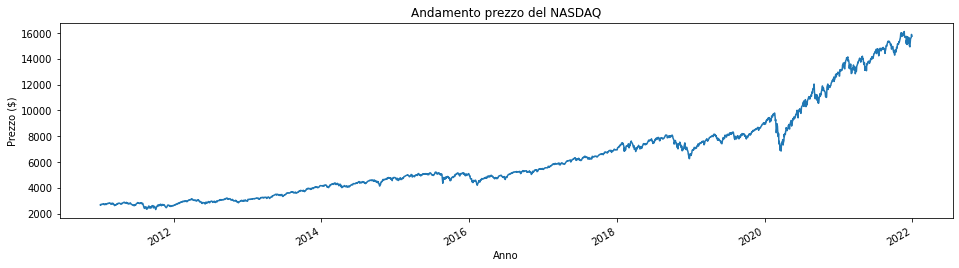

In [135]:
open.plot(figsize=(16,4))
plt.title("Andamento prezzo del NASDAQ")
plt.xlabel("Anno")
plt.ylabel("Prezzo ($)");

Utilizzando la libreria plotly è possibile visualizzare in un unico grafico 4 features (Open, High, Low, Close)

In [136]:
import plotly.graph_objects as go

In [137]:
candlestick = go.Candlestick(
                            x=data.index,
                            open=open,
                            high=high,
                            low=low,
                            close=close
                            )


Il grafico è rappresentato mediante l'utilizzo di Candele, queste ultime rappresentano l'andamento del prezzo di una giornata.

<img src="candlestick.jpeg" alt="Candlestick" style="width:700px;"/>


In [138]:
from ipywidgets.widgets import interact
from datetime import timedelta, datetime

Mostriamo tramite grafico a candele gli ultimi 100 giorni.

In [139]:
termDate = datetime(2021, 12, 31)
DD = timedelta(days=100)
earlier = termDate - DD
earlier_str = earlier.strftime("%Y-%m-%d")

In [140]:
@interact(ymin=(0,13000,500), ymax=(11000,30000,500))
def plot_candlestick(ymin=13000, ymax=17000):    
    fig = go.Figure(data=[candlestick])
    fig.update_layout(
        width=1000, height=700,
        title="Andamento prezzo NASDAQ Candlestick",
        yaxis_title='Prezzo ($)'
    )
    fig.update_xaxes(type="date", range=[earlier_str, termDate])
    fig.update_yaxes(range=[ymin,ymax])
    fig.show()

interactive(children=(IntSlider(value=13000, description='ymin', max=13000, step=500), IntSlider(value=17000, …

Mostriamo ora alcune statistiche generali raggruppate per anno, come:
- Media
- Deviazione Standard
- Min e Max
- Quartili


In [141]:
hlm = (high + low) / 2
hlm.groupby(hlm.index.year).describe()

,count,mean,std,min,25%,50%,75%,max
Date,,,,,,,,
2011,252.0,2676.244785,122.032911,2352.779907,2604.299988,2693.872559,2776.783752,2873.795044
2012,250.0,2963.932197,113.122627,2640.204956,2894.392517,2975.859985,3050.596283,3187.510010
2013,252.0,3539.060040,306.827311,3089.994995,3243.216248,3492.297485,3777.697510,4169.250000
2014,252.0,4373.320877,211.983366,3997.234985,4202.081360,4355.214966,4535.299988,4806.310059
2015,252.0,4943.834490,157.062179,4493.520020,4838.318787,4984.995117,5069.158813,5216.715088
2016,252.0,4985.242454,297.691485,4251.489990,4759.471130,4951.322510,5239.396118,5490.989990
2017,251.0,6231.484259,394.575343,5425.280029,5885.290161,6239.820068,6491.050049,6989.715088
2018,251.0,7426.148126,367.453986,6272.675049,7146.000122,7394.964844,7732.107544,8101.434814
2019,252.0,7934.295049,471.745590,6528.669922,7678.299988,7964.969971,8194.679871,9019.660156


Guardando i risultati notiamo come i valori della colonna `count` variano a seconda dell'anno, questo accade perché la borsa non è aperta 24/7 ma è chiusa in alcuni giorni, ad esempio i festivi.

Notiamo anche come la media (`mean`) del prezzo aumenta ogni anno, il che rende il NASDAQ un indice solido.

Notiamo anche come nel 2020, l'anno della pandemia, ci sia stata una deviazione standard (`std`) molto alta rispetto agli altri anni.

## Prevedere il valore di chiusura a inizio giornata

La variabile da predire è la features "Close" relativa alla data odierna.

In [142]:
y = close

`high`, `low`, `volume` non possono essere utilizzate in quanto il loro valore non è noto a inizio giornata.
Attualmente l'unica feature utilizzabile è il valore `open`.

In [143]:
features = {"Open" : open}
X = pd.DataFrame(features)

Suddividiamo i dati in un training set e in un validation set con la funzione `split_data`. L'anno inserito verrà utilizzato come test e tutti i precedenti (fino al 2011) verranno utilizzati come training.

In [144]:
def split_data(X, y, split):
    lowerRange = X.index.year < split
    upperRange = (X.index.year > split-1) & (X.index.year < split+1)
    X_train = X.loc[lowerRange]
    y_train = y.loc[lowerRange]
    X_val = X.loc[upperRange]
    y_val = y.loc[upperRange]
    return X_train, X_val, y_train, y_val

## Test 1: Regressione Lineare

Creiamo il training e validation set con la funzione `split_data` e addestriamo un modello di regressione lineare  calcolandone R<sup>2</sup>.

In [145]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
X_train, X_val, y_train, y_val = split_data(X, y, 2020)
model.fit(X_train,y_train)
model.score(X_val, y_val)

0.9921675537422088

In [146]:
def plot_model_on_data(X, y, model=None):
    plt.figure(figsize=(10, 7))
    plt.scatter(X["Open"], y)
    if model is not None:
        xlim, ylim = plt.xlim(), plt.ylim()
        line_x = np.linspace(xlim[0], xlim[1], 100)
        line_y = model.predict(line_x[:, None])
        plt.plot(line_x, line_y, c="red", lw=3)
        plt.xlim(xlim); plt.ylim(ylim)
    plt.grid()
    plt.xlabel("Open"); plt.ylabel("Delta")

/opt/homebrew/Caskroom/miniforge/ml/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



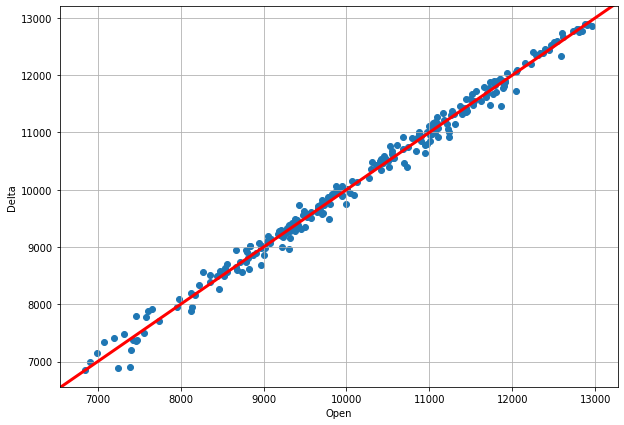

In [147]:
plot_model_on_data(X_val,y_val,model)

Il punteggio R<sup>2</sup> del modello risulta molto alto. Questo è dovuto al fatto che i valore `Open` e `Close` sono molto correlati.

Per avere un riscontro dell'effetiva efficienza del modello calcoleremo il guadagno effettivo di un possibile investitore.

Per far ciò implementeremo un protocollo di trading che dati i valori di chiusura reali e predetti restituisce il guadagno effettivo.

**La cifra investita in questo caso è pari al valore di apertura che varia giornalmente**.

Definiamo la variabile differenza $\Delta_d=C_d-O_d$ tra il valore di chiusura giornaliero $C_d$ e di apertura $O_d$

In [148]:
delta = close - open

- Poniamo questo come il valore che **deve essere predetto** dal modello
- L'investitore agirà in base alla predizione $\hat{\Delta}_d$
  - se $\hat{\Delta}_d > 0$, acquista un titolo a inizio giornata e lo rivende alla fine (LONG)
  - se $\hat{\Delta}_d < 0$, vende un titolo a inizio giornata e lo ricompra alla fine (SHORT)

### Importiamo alcune funzioni utili 

Possiamo definire una metrica "guadagno" per validare il modello, che restituisca il guadagno totale di un investitore che opera nel periodo a cui si riferisce il validation set

In [149]:
def gain(D, D_pred):
    growth = D_pred > 0
    decline = D_pred < 0
    return D[growth].sum() - D[decline].sum()

Il ROI (Return on investiment) esprime il guadagno di una o più operazioni in borsa in rapporto all'investimento iniziale.

In [150]:
def roi(D, D_pred):
    mean_open = open.reindex_like(D).mean()
    return gain(D, D_pred)/ mean_open

Definiamo anche una funzione che stampi le metriche di valutazione del modello.

In [151]:
def print_eval(X, y, model):
    preds = model.predict(X)
    print("Gain: {:.2f}$".format(gain(y, preds)))
    print(" ROI: {:.3%}".format(roi(y, preds)))

La funzione `prepare_data` restituisce un Dataframe con le features indicate e una serie con i valori della variabile da predire.

In [152]:
def prepare_data(features, delta):
    X = pd.DataFrame(features)
    X.dropna(inplace=True)
    y = delta.reindex_like(X)
    return X, y

Addestriamo ora invece un modello di regressione lineare prevedendo il delta e calcoliamo il `gain` e il `ROI` operando su tutto il 2020.

In [153]:
X, y = prepare_data(features, delta)
X_train, X_val, y_train, y_val = split_data(X, y, 2020)
model = LinearRegression()
model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

Gain: -1673.49$
 ROI: -16.414%


Il risultato non è per nulla soddisfacente.

## Aggiungiamo Features
Definiamo alcune funzioni che ci permetteranno di calcolare alcuni indicatori molto comuni nel mondo funanziario.

- **MACD**: *Moving Average Convergence/Divergence* è un oscillatore di momentum che segue il trend del prezzo utilizzando due medie mobili esponenziali.
- **SMA**: *Simple Moving Average* è un indice calcolato in base alle medie aritmetiche dei valori di prezzo precedenti.
- **EMA**: *Exponential Moving Average* è un indice utile per a identificare i trend al rialzo o al ribasso di titoli e valute.
- **RSI**: *Relative Strength Index* è un indicatore che segnala la forza intrinseca di un titolo.
- **MFI**: *Money Flow Index* è un indicatore di momentum che misura il flusso di denaro dentro e fuori un titolo in un periodo di tempo specifico.
- **ATR**: *Average True Range* è un indicatore che misura la volatilità.
- **FI**: *Force Index* è un indicatore che utilizza il prezzo e i volume per determinare la forza che sta dietro ad un movimento del mercato

In più aggiungiamo 4 features che possono risultare utili: i prezzi all'apertura traslati di 1,2,3,4 giorni.

In [154]:
features = {
    "Open": open,
    "OpenShift1": open.shift(1),
    "OpenShift2": open.shift(2),
    "OpenShift3": open.shift(3),
    "OpenShift4": open.shift(4),
}

In [155]:
# Calcolo del MACD
def computeMACD (n_fast, n_slow, n_smooth):
    data = open
    fastEMA = data.ewm(span=n_fast, min_periods=n_slow).mean()
    slowEMA = data.ewm(span=n_slow, min_periods=n_slow).mean()
    MACD = pd.Series(fastEMA-slowEMA, name = 'MACD')
    return MACD

# Funzione utilizzata per il calcolo del singolo SMA
def calculateSMA(ndays): 
    SMA = pd.Series(open.rolling(ndays).mean(), name = 'SMA') 
    return SMA

# Calcolo della variazione percentuale tra 2 SMA
def SMA(first, second):
    sma1 = calculateSMA(first)
    sma2 = calculateSMA(second)
    sma = (np.array(sma2) - np.array(sma1)) / np.array(sma2)
    sma = pd.Series(data=sma, index=data.index)
    return sma

# Funzione utilizzata per il calcolo del singolo EMA
def calculateEMA(prices, days, smoothing=2):
    ema = [sum(prices[:days]) / days]
    for price in prices[days:]:
        ema.append((price * (smoothing / (1 + days))) + ema[-1] * (1 - (smoothing / (1 + days))))
    return ema

# Calcolo della variazione percentuale tra 2 EMA
def EMA(first, second):
    ema1 = calculateEMA(open, first)
    ema2 = calculateEMA(open, second)
    ema = (np.array(ema2) - np.array(ema1[(second-first):])) / np.array(ema2)
    ema = pd.Series(data=ema, index=data[(second-1):].index)
    return ema

# Calcolo del RSI
# Il parametro close intende il valore di chiusura del giorno precedente ovvero quello di apertura del giorno corrente
def rsi(close, periods = 14):
    close_delta = close.diff()
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

# Calcolo del MFI
def mfi(high, low, close, volume, n=14): 
    typical_price = (high + low + close)/3
    money_flow = typical_price * volume
    mf_sign = np.where(typical_price > typical_price.shift(1), 1, -1)
    signed_mf = money_flow * mf_sign
    mf_avg_gain = signed_mf.rolling(n).apply(lambda x: ((x > 0) * x).sum(), raw=True)
    mf_avg_loss = signed_mf.rolling(n).apply(lambda x: ((x < 0) * x).sum(), raw=True)
    # Spostiamo la colonna di 1 in avanti così da avere per ogni riga il valore dell'MFI del giorno precedente.
    return (100 - (100 / (1 + (mf_avg_gain / abs(mf_avg_loss))))).shift(1).to_numpy()

# Calcolo ATR
def atr(high, low, close, n=14):
    high_low = high - low
    high_cp = np.abs(high - close.shift())
    low_cp = np.abs(low - close.shift())
    df = pd.concat([high_low, high_cp, low_cp], axis=1)
    true_range = np.max(df, axis=1)
    average_true_range = true_range.rolling(14).mean()
    # Spostiamo la colonna di 1 in avanti così da avere per ogni riga il valore dell'ATR del giorno precedente
    return average_true_range.shift(1) 

# Calcolo FI
def forceIndex(data, ndays): 
    FI = pd.Series(open.diff(ndays) * volume, name = 'ForceIndex') 
    return FI


In [156]:
# Aggiungiamo gli indici al dataset
data["EMA5-20"] = EMA(5,20)
data["EMA8-15"] = EMA(8,15)
data["EMA20-50"] = EMA(20,50)
data["SMA5-20"] = SMA(5,20)
data["SMA8-15"] = SMA(8,15)
data["SMA20-50"] = SMA(20,50)
data["RSI"] = rsi(open)
data["MACD"] = computeMACD(12, 26, 9)
data["MFI"] = mfi(high, low, close, volume, 14)
data["ATR"] = atr(high, low, close, 14)
data["FI-13"] = forceIndex(data, 13)
data["FI-50"] = forceIndex(data, 50)

# Creiamo le features a partire dai dati appena calcolati
features["EMA5-20"] = data["EMA5-20"] 
features["EMA8-15"] = data["EMA8-15"]
features["EMA20-50"] = data["EMA20-50"] 
features["SMA5-20"] = data["SMA5-20"] 
features["SMA8-15"] = data["SMA8-15"]
features["SMA20-50"] = data["SMA20-50"] 
features["MACD"] = data["MACD"]
features["RSI"] = data["RSI"] 
features["MFI"] = data["MFI"] 
features["ATR"] = data["ATR"] 
features["FI-13"] = data["FI-13"] 
features["FI-50"] = data["FI-50"]

In [157]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## Test delle features
Verifichiamo quali features usare per ottenere il risultato migliore.
Per fare ciò creiamo una funzione che testando TUTTE le combinazioni di features ci restituisce la combinazione migliore.

In [158]:
import itertools

def getBestFeatures(features, model):
    keys = np.array(list(features.keys()))
    # Creiamo una lista di tutte le possibili sequenze binarie lunghe len(keys)-1 (il numero di features-1)
    mylist = ["1" + "".join(seq) for seq in itertools.product("01", repeat=len(keys)-1)]
    dict2 = {x:features[x] for x in keys}

    # Permette di convertire una string binaria in un array di booleani
    def str2bool(v):
        v_bool = [True] # Il primo valore sarà sempre True visto che vogliamo sempre la feature Open
        for i in v[1:]:
            v_bool.append(i=='1')
        return np.array(v_bool)

    best_ROI = 0
    best_features = {}

    for i in range(0,len(mylist)):
        dict2 = {x:features[x] for x in keys[str2bool(mylist[i])]}
        X, y = prepare_data(dict2, delta)
        # Come anno è stato selezionato il 2017 perché è un valore intermedio tra il 2011 e il 2021
        X_train, X_val, y_train, y_val = split_data(X, y, 2017)
        
        # Per questioni di tempo utilizziamo solo 1 modello: LinearRegression()
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        if roi(y_val, preds) > best_ROI:
            best_ROI = roi(y_val, preds)
            best_features = dict2
            
    # L'algoritmo restuituirà le features migliori e il miglior ROI ottenuto
    return best_features, best_ROI

Verifichiamo come si comporta il nostro modello utilizzando tutte le features disponibili.

In [159]:
X, y = prepare_data(features, delta)
X_train, X_val, y_train, y_val = split_data(X, y, 2020)
model = LinearRegression()
model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

Gain: -999.12$
 ROI: -9.799%


In [160]:
import time
start_time = time.time()
new_features, new_ROI = getBestFeatures(features, LinearRegression())
print("Tempo di esecuzione per la ricerca delle features migliori: %s secondi" % (time.time() - start_time))

Tempo di esecuzione per la ricerca delle features migliori: 202.37990808486938 secondi


In [161]:
print(new_features.keys())

dict_keys(['Open', 'OpenShift1', 'OpenShift2', 'OpenShift4', 'EMA5-20', 'EMA20-50', 'SMA5-20', 'RSI', 'MFI'])


Le feature selezionate sono 'Open', 'OpenShift1', 'OpenShift2', 'OpenShift4', 'EMA5-20', 'EMA20-50', 'SMA5-20', 'RSI', 'MFI'

In [162]:
X, y = prepare_data(new_features, delta)
X_train, X_val, y_train, y_val = split_data(X, y, 2020)
linearRegressionModel = LinearRegression()
linearRegressionModel.fit(X_train, y_train)
print_eval(X_val, y_val, linearRegressionModel)

Gain: 1904.34$
 ROI: 18.678%


Osserviamo che con la selezione delle features migliori abbiamo ottenuto un ROI più alto.

In [163]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

linearRegressionModelStd = Pipeline([
    ("scale", StandardScaler()),
    ("lr", LinearRegression())
])
linearRegressionModelStd.fit(X_train, y_train)
print_eval(X_val, y_val, linearRegressionModelStd)

Gain: 1904.34$
 ROI: 18.678%


In [164]:
pd.DataFrame({
    "linear": linearRegressionModel.coef_,
    "scaled": linearRegressionModelStd.named_steps["lr"].coef_
}, index=X.columns)

,linear,scaled
Open,-0.111537,-198.430776
OpenShift1,0.071120,126.442558
OpenShift2,0.026867,47.732506
OpenShift4,0.013415,23.798815
EMA5-20,-905.543245,-12.074707
EMA20-50,393.771190,5.361893
SMA5-20,690.747624,12.288579
RSI,0.439817,4.847801
MFI,-0.091282,-1.367235


- In tutti e due i modelli, dai segni dei coefficienti possiamo vedere quali fenomeni influiscono positivamente e negativamente sul prezzo
- Con la standardizzazione delle feature otteniamo valori su scale simili, che possiamo confrontare alla pari
  - ad es. nel modello non standardizzato il coefficiente di `EMA5-20` è alto in valore assoluto perché i valori di tale variabile sono bassi
  - nel modello con standardizzazione assumono invece più peso ad esempio il prezzo di apertura (`Open`) e il prezzo di apertura del giorno precedente (`OpenShift1`)

## Test 2: Regressione Polinomiale

Addestriamo ora un modello di regressione polinomiale

In [391]:
from sklearn.preprocessing import PolynomialFeatures

X, y = prepare_data(features, delta)
X_train, X_val, y_train, y_val = split_data(X, y, 2020)
polynomialRegressionModel = Pipeline([
    ("poly", PolynomialFeatures(degree=4, include_bias=False)),
    ("scale", StandardScaler()),
    ("regr", LinearRegression())
])
polynomialRegressionModel.fit(X_train, y_train)
print_eval(X_val,y_val,model)

Gain: 2916.40$
 ROI: 28.604%


Otteniamo un ROI migliore rispetto a quello della regressione lineare.

## Test 3: Regressione Ridge

Proviamo ora il modello di regressione Ridge con regolarizzazione per evitare che i coefficienti crescano troppo.

Creiamo un nostro scorer che valuti i modelli in base al ROI

In [165]:
from sklearn.metrics import make_scorer
roi_scorer = make_scorer(roi, greater_is_better=True)

### Validazione k-fold per serie temporali

- Come alternativa allo split `KFold`, scikit-learn offre il `TimeSeriesSplit(k)` per la nostra situazione in cui vogliamo però mantenere l'ordine temporale in training e validation set

In [166]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(11) #11 anni dal 2011 al 2022

In [167]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

X, y = prepare_data(new_features, delta)
model = Pipeline([
    ("scale",  StandardScaler()),
    ("linreg", Ridge())
])

grid = {"linreg__alpha": [0.1, 1, 10, 50]}
gs = GridSearchCV(model, param_grid=grid, scoring=roi_scorer, cv=tss)
gs.fit(X, y)
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linreg__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008014,0.006117,0.002255,0.001503,0.1,{'linreg__alpha': 0.1},0.058566,-0.147950,-0.053027,0.005561,0.167542,0.067635,0.007224,0.125928,0.140708,0.241799,0.063338,0.061575,0.103259,1
1,0.002295,0.000814,0.001104,0.000212,1,{'linreg__alpha': 1},0.022940,-0.160276,-0.027370,0.028247,0.216820,0.137975,-0.041895,0.011380,-0.042139,0.229107,0.161164,0.048723,0.116705,2
2,0.001366,0.000111,0.000810,0.000104,10,{'linreg__alpha': 10},-0.004830,-0.139849,-0.036286,-0.004966,0.073174,-0.022045,0.036510,-0.064211,-0.115495,0.125826,0.132548,-0.001784,0.084705,3


- Per la regressione Ridge il parametro migliore è $\alpha$=0.1 con un profitto medio annuo del 6.1%:
- **Ottenendo profitto migliore utilizzando le features selezionate `new_features`**
- *Utilizzando invece tutte le features otteniamo un profitto del 4.8%*

In [168]:
ridgeModel = Pipeline([
    ("scale",  StandardScaler()),
    ("linreg", Ridge(alpha=0.1))
])
ridgeModel.fit(X_train, y_train)
print_eval(X_val, y_val, ridgeModel)

Gain: 3478.34$
 ROI: 34.116%


## Test 4: ElasticNet

In [169]:
from sklearn.linear_model import ElasticNet
X, y = prepare_data(features, delta)
model = Pipeline([
    ("scale",  StandardScaler()),
    ("linreg", ElasticNet())
])

grid = {"linreg__alpha":  [1, 2, 3, 5], "linreg__l1_ratio": [0.1, 0.2, 0.3, 0.4, 0.5]}
gs = GridSearchCV(model, param_grid=grid, scoring=roi_scorer, cv=tss)
gs.fit(X, y)
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linreg__alpha,param_linreg__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,...,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,mean_test_score,std_test_score,rank_test_score
11,0.001838,0.000486,0.000888,0.000186,3,0.2,"{'linreg__alpha': 3, 'linreg__l1_ratio': 0.2}",-0.022005,-0.157559,-0.030941,...,0.104191,0.208429,0.174931,-0.043080,-0.010256,0.359223,0.078736,0.073062,0.138109,1
8,0.001642,0.000166,0.000801,0.000114,2,0.4,"{'linreg__alpha': 2, 'linreg__l1_ratio': 0.4}",-0.022005,-0.157559,-0.030941,...,0.128933,0.124732,0.197573,-0.028569,-0.000009,0.347559,0.075512,0.071180,0.131736,2
9,0.001614,0.000161,0.000753,0.000087,2,0.5,"{'linreg__alpha': 2, 'linreg__l1_ratio': 0.5}",-0.022005,-0.157559,-0.030941,...,0.148839,0.168290,0.210738,-0.022782,0.046942,0.203526,0.081493,0.066509,0.110502,3


- Per la regressione ElasticNet i parametri migliori sono $\alpha$=3 e L1_RATIO=0.2 con un profitto medio annuo del 7.3%:

- **Ottenendo profitto migliore utilizzando tutte le features**

- *Utilizzando invece le features selezionate otteniamo un profitto del 6.4%*

In [170]:
X, y = prepare_data(features, delta)
X_train, X_val, y_train, y_val = split_data(X, y, 2020)
elasticNetModel = Pipeline([
    ("scale",  StandardScaler()),
    ("linreg", ElasticNet(alpha=3, l1_ratio=0.2))
])
elasticNetModel.fit(X_train, y_train)
print_eval(X_val, y_val, elasticNetModel)

Gain: 1082.98$
 ROI: 10.622%


I risultati ottenuti sono simili, in quanto la regressione ElasticNet permette di penalizzare le variabili irrilevanti, che è lo stesso scopo della nostra funzione: `getBestFeatures()`

## Test 5: Regressione con alberi decisionali

In [171]:
from sklearn.ensemble import RandomForestRegressor

In [172]:
X, y = prepare_data(new_features, delta)
X_train, X_val, y_train, y_val = split_data(X, y, 2020)

In [173]:
print(sklearn.__version__)

1.1.1


In [174]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report

rfc = Pipeline([
    ('std', StandardScaler()),
    ('rfc', RandomForestRegressor(n_jobs=-1, random_state=42))
])

parameters = {
    'rfc__n_estimators': [200, 300],
    'rfc__max_depth': [4, 6, 8, 10],
    'rfc__min_samples_leaf': [2, 4, 6],
    'rfc__min_samples_split': [2, 5, 10],
}
    

rfc_gs = GridSearchCV(rfc, parameters, cv=tss, n_jobs=-1, scoring=roi_scorer)
rfc_gs.fit(X.values, y)


CPU times: user 2.59 s, sys: 478 ms, total: 3.07 s
Wall time: 1min 48s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=11, test_size=None),
             estimator=Pipeline(steps=[('std', StandardScaler()),
                                       ('rfc',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'rfc__max_depth': [4, 6, 8, 10],
                         'rfc__min_samples_leaf': [2, 4, 6],
                         'rfc__min_samples_split': [2, 5, 10],
                         'rfc__n_estimators': [200, 300]},
             scoring=make_scorer(roi))

In [175]:
pd.DataFrame(rfc_gs.cv_results_).sort_values("mean_test_score", ascending=False).head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfc__max_depth,param_rfc__min_samples_leaf,param_rfc__min_samples_split,param_rfc__n_estimators,params,split0_test_score,...,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,mean_test_score,std_test_score,rank_test_score
15,1.059956,0.318104,0.037192,0.018984,4,6,5,300,"{'rfc__max_depth': 4, 'rfc__min_samples_leaf':...",0.106674,...,0.198141,-0.045745,-0.00086,0.199558,-0.018226,0.108251,0.251598,0.063603,0.117345,1


In [350]:
X, y = prepare_data(new_features, delta)
X_train, X_val, y_train, y_val = split_data(X, y, 2020)
randomForestModel = Pipeline([
    ('std', StandardScaler()),
    ('rfc', RandomForestRegressor(n_jobs=-1, n_estimators=300, max_depth=4, min_samples_leaf=6, min_samples_split=5, random_state=42))
])

randomForestModel.fit(X_train, y_train)
print_eval(X_val, y_val, randomForestModel)

Gain: 1182.39$
 ROI: 11.597%


- Con l'utilizzo della RandomForest otteniamo un profitto medio annuo del 6.3%:

- **Ottenendo profitto migliore utilizzando le features selezionate `new_features`**

- *Utilizzando invece tutte le features otteniamo un profitto del 4.1%*

## Test 6: XGBoost

In [177]:
from xgboost import XGBRegressor

In [353]:
X, y = prepare_data(new_features, delta)
X_train, X_val, y_train, y_val = split_data(X, y, 2020)

xgbm = XGBRegressor(objective='reg:squarederror',reg_alpha=0, reg_lambda=1.0, n_estimators=300)
xgbm.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1.0, ...)

In [354]:
print_eval(X_train, y_train, xgbm)
print_eval(X_val, y_val, xgbm)

Gain: 66304.66$
 ROI: 1310.401%
Gain: 4104.32$
 ROI: 40.255%


Xgboost senza tuning degli iperparametri restituisce un ROI del 40%

## Test 7: LightGBM

Proviamo ora il LightGBM, alcuni vantaggi sono:
- training più veloce e modelli spesso più efficaci
- minore utilizzo della memoria
- migliore accuratezza
- supporto alla programmazione parallela, distribuita e possibilità di utilizzo della GPU

In [181]:
from lightgbm import LGBMRegressor

In [182]:
%%time
X, y = prepare_data(new_features, delta)
X_train, X_val, y_train, y_val = split_data(X, y, 2020)

lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)

CPU times: user 2.13 s, sys: 1.3 s, total: 3.43 s
Wall time: 1.51 s


LGBMRegressor()

In [183]:
print_eval(X_val, y_val, lgbm)

Gain: 4608.22$
 ROI: 45.198%


Pur senza il tuning dei parametri il modello LGBM ha un ROI ancora più elevato. 

## Confronto con un modello casuale

Per avere una valutazione più completa del modello, mettiamolo a confronto con quello che accadrebbe prendendo decisioni casuali.

Consideriamo un modello che predica dei valori $\hat{\Delta}_d$ casuali, ma con la stessa distribuzione dei valori $\Delta_d$ reali.

Disegnando un istogramma, vediamo che $\Delta_d$ ha una distribuzione normale.

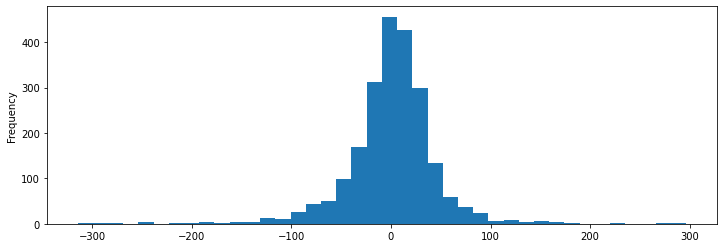

In [184]:
X, y = prepare_data(new_features, delta)
X_train, X_val, y_train, y_val = split_data(X, y, 2020)

y_train.plot.hist(bins=40, figsize=(12, 4));

- Consideriamo una distribuzione normale con media e deviazione standard pari a quelle di `y_train` e generiamo tanti campioni quanti i valori in `y_val`
- Per valutare con maggiore affidabilità l'efficacia di un modello casuale, dobbiamo eseguire test multipli con seed differenti

In [185]:
rois = []
for s in range(1000):
    np.random.seed(s)
    preds = np.random.normal(y_train.mean(), y_train.std(), len(y_val))
    rois.append(roi(y_val, preds))
print(np.mean(rois))

0.00994863721797587


Otteniamo un ROI medio prossimo allo 0

# Guadagni
### Verifichiamo i guadagni per ogni anno e con ogni algoritmo studiato

- Per fare ciò andiamo a costruire una funzione che permetta, dato l'anno, di stampare un grafico del guadagno per ogni algoritmo.

In [471]:
shiftedOpenFeatures = {
    "Open": open,
    "OpenShift1": open.shift(1),
    "OpenShift2": open.shift(2),
    "OpenShift3": open.shift(3),
    "OpenShift4": open.shift(4),
}

In [480]:
from tabulate import tabulate

def chartFromYear(anno): 
    
    feats = [features,new_features,shiftedOpenFeatures]

    #LinearRegression
    linearRegressionResultsArray = []
 
    for f in feats:
        X, y = prepare_data(f, delta)
        X_train, X_val, y_train, y_val = split_data(X, y, anno)
        linearRegressionModel.fit(X_train, y_train)
        linReg = roi(y_val, linearRegressionModel.predict(X_val)) * 100
        linearRegressionResultsArray.append(linReg)
    
    #PolynomialRegression
    polyRegressionResultsArray = []
    
    for f in feats:
        X, y = prepare_data(f, delta)
        X_train, X_val, y_train, y_val = split_data(X, y, anno)
        polynomialRegressionModel.fit(X_train, y_train)
        polReg = roi(y_val, polynomialRegressionModel.predict(X_val)) * 100
        polyRegressionResultsArray.append(polReg)
    
    #Ridge
    ridgeResultsArray = []
    
    for f in feats:
        X, y = prepare_data(f, delta)
        X_train, X_val, y_train, y_val = split_data(X, y, anno)
        ridgeModel.fit(X_train, y_train)
        ridge = roi(y_val, ridgeModel.predict(X_val)) * 100
        ridgeResultsArray.append(ridge)
    
    #ElasticNet
    elasticNetResultsArray = []
    for f in feats:
        X, y = prepare_data(f, delta)
        X_train, X_val, y_train, y_val = split_data(X, y, anno)
        elasticNetModel.fit(X_train, y_train)
        elNet = roi(y_val, elasticNetModel.predict(X_val)) * 100
        elasticNetResultsArray.append(elNet)
    
    #RandomForest
    randomForestResultsArray = []
    for f in feats:
        X, y = prepare_data(f, delta)
        X_train, X_val, y_train, y_val = split_data(X, y, anno)
        randomForestModel.fit(X_train, y_train)
        randFor = (roi(y_val, randomForestModel.predict(X_val)) * 100)
        randomForestResultsArray.append(randFor)
    
    #XGBoost
    xgBoostResultsArray = []
    for f in feats:
        X, y = prepare_data(f, delta)
        X_train, X_val, y_train, y_val = split_data(X, y, anno)
        xgbm.fit(X_train, y_train)
        xgb = (roi(y_val, xgbm.predict(X_val)) * 100)
        xgBoostResultsArray.append(xgb)
    
    #LightBoost
    lightBoostResultsArray = []
    for f in feats:
        X, y = prepare_data(f, delta)
        X_train, X_val, y_train, y_val = split_data(X, y, anno)
        lgbm.fit(X_train, y_train)
        light = (roi(y_val, lgbm.predict(X_val)) * 100)
        lightBoostResultsArray.append(light)

    algo = ['LinearRegression',
            'PolynomialRegression',
            'Ridge',
            'ElasticNet',
            'RandomForest', 
            'XGBoost', 
            'LightBoost']

    # create data
    df = pd.DataFrame([[algo[0], linearRegressionResultsArray[0], linearRegressionResultsArray[1], linearRegressionResultsArray[2]],
                       [algo[1], polyRegressionResultsArray[0], polyRegressionResultsArray[1], polyRegressionResultsArray[2]],
                       [algo[2], ridgeResultsArray[0], ridgeResultsArray[1], ridgeResultsArray[2]],
                       [algo[3], elasticNetResultsArray[0], elasticNetResultsArray[1], elasticNetResultsArray[2]],
                       [algo[4], randomForestResultsArray[0], randomForestResultsArray[1], randomForestResultsArray[2]],
                       [algo[5], xgBoostResultsArray[0], xgBoostResultsArray[1], xgBoostResultsArray[2]],
                       [algo[6], lightBoostResultsArray[0], lightBoostResultsArray[1], lightBoostResultsArray[2]]
                       ],
                      columns=['MODELLI', 'Features', 'New_Features', 'Shift_Open_Features'])

    # plot grouped bar chart
    df.plot(x='MODELLI',
            figsize=(15,7),
            kind='bar',
            stacked=False,
            title='Grouped Bar Graph with dataframe',
            rot=0);
    
    data = [[algo[0], linearRegressionResultsArray[0], linearRegressionResultsArray[1], linearRegressionResultsArray[2]],
                       [algo[1], polyRegressionResultsArray[0], polyRegressionResultsArray[1], polyRegressionResultsArray[2]],
                       [algo[2], ridgeResultsArray[0], ridgeResultsArray[1], ridgeResultsArray[2]],
                       [algo[3], elasticNetResultsArray[0], elasticNetResultsArray[1], elasticNetResultsArray[2]],
                       [algo[4], randomForestResultsArray[0], randomForestResultsArray[1], randomForestResultsArray[2]],
                       [algo[5], xgBoostResultsArray[0], xgBoostResultsArray[1], xgBoostResultsArray[2]],
                       [algo[6], lightBoostResultsArray[0], lightBoostResultsArray[1], lightBoostResultsArray[2]]
                       ]
    col_names = ['MODELLI', 'Features', 'New_Features', 'Shift_Open_Features']
    print(tabulate(data, headers=col_names))
    

## Risultati 2013

MODELLI                 Features    New_Features    Shift_Open_Features
--------------------  ----------  --------------  ---------------------
LinearRegression        -15.6692        -17.1471              -19.5508
PolynomialRegression    -13.7145         -2.1413                4.53533
Ridge                   -14.5915        -17.0391              -19.5508
ElasticNet              -17.0274        -17.0274              -17.0274
RandomForest            -14.704         -16.5114              -15.8445
XGBoost                 -13.2866        -14.6916              -12.9509
LightBoost              -15.8361        -12.0868              -14.6357


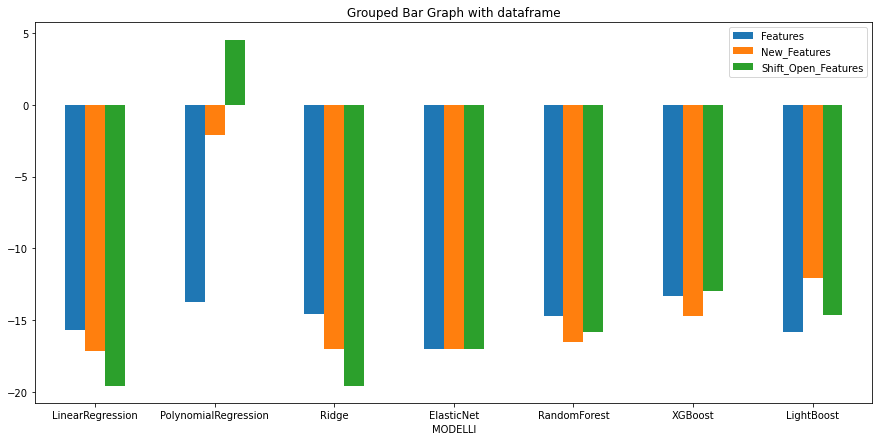

In [481]:
chartFromYear(2013)

Nell'anno 2013 tutti i nostri modelli sarebbero andati in perdita, la perdita minore è stata fatta dal modello `LightBoost`. La scarsa performance è dovuta, probabilmente, alla scarsità di data set per il training (solo 1 anno). 

## Risultati 2014

MODELLI                 Features    New_Features    Shift_Open_Features
--------------------  ----------  --------------  ---------------------
LinearRegression       -6.66101        -0.305489               8.20266
PolynomialRegression    6.88052         6.03847               16.4771
Ridge                  -6.176          -3.20964                7.37891
ElasticNet             -0.020697       -0.020697              -0.020697
RandomForest           13.1721        -15.96                  10.9442
XGBoost                -0.283626      -13.2136                -2.9345
LightBoost              6.51759         3.24489                0.861112


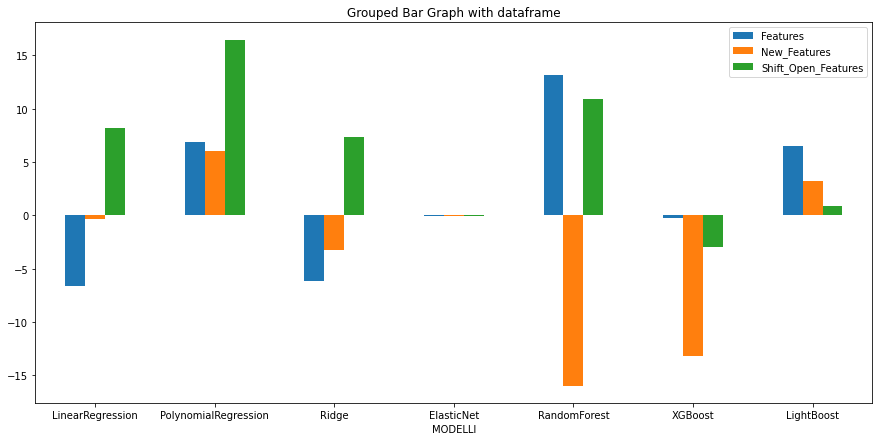

In [482]:
chartFromYear(2014)

Nel 2014, il modello più promettente è `RandomForest` che ci ha procurato un guadagno del 9.51%, seguito dalla rete neurale che ha totalizzato un ROI del 8.4%.

## Risultati 2015

MODELLI                 Features    New_Features    Shift_Open_Features
--------------------  ----------  --------------  ---------------------
LinearRegression        23.5529        -6.40071               -5.09048
PolynomialRegression   -16.5205        20.7956               -23.7364
Ridge                   19.5452        -3.84083               -6.72427
ElasticNet              15.9965         0.133328               0.133328
RandomForest            18.3566        20.2419                 9.96183
XGBoost                 13.7103         4.63187                0.221772
LightBoost              -4.79797       -8.44859                0.610815


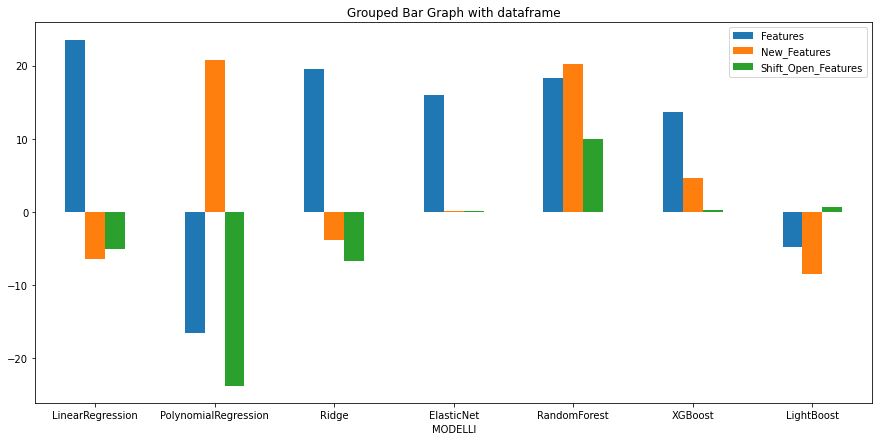

In [483]:
chartFromYear(2015)

Anche nel 2015 il modello più remunerativo è stato il `RandomForest` con un guadagno in percentuale del 23.63%.

## Risultati 2016

MODELLI                 Features    New_Features    Shift_Open_Features
--------------------  ----------  --------------  ---------------------
LinearRegression        12.6873         9.23919                18.1868
PolynomialRegression    14.1405        -5.88862               -15.3184
Ridge                   11.8084        11.0607                 20.0962
ElasticNet               2.32815        8.40852                 9.29904
RandomForest            16.2279         7.53665                 7.34698
XGBoost                  9.07703        1.81019                -1.69812
LightBoost              12.0125        -0.647591                0.15384


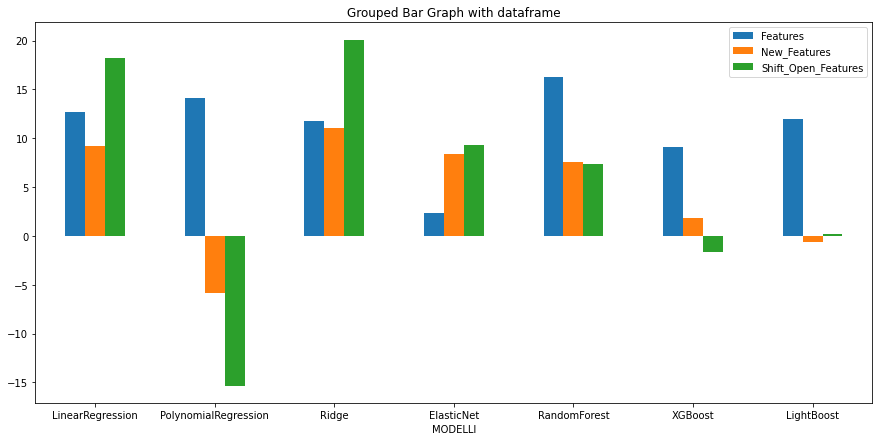

In [484]:
chartFromYear(2016)

Nel 2016, come nei 2 anni precedenti, il modello con ROI più elevato è stato `RandomForest`, totalizzando il 27.71%.

## Risultati 2017

MODELLI                 Features    New_Features    Shift_Open_Features
--------------------  ----------  --------------  ---------------------
LinearRegression        12.0887         19.7538                 6.47357
PolynomialRegression    -0.05149         6.42474              -11.9224
Ridge                   12.4586         19.4092                 7.03508
ElasticNet              23.6558          8.47669                8.47669
RandomForest            -8.47669        -8.47669               -8.47669
XGBoost                 -6.31311        -3.79465               -8.36567
LightBoost               1.44055        -2.20799               -8.47669


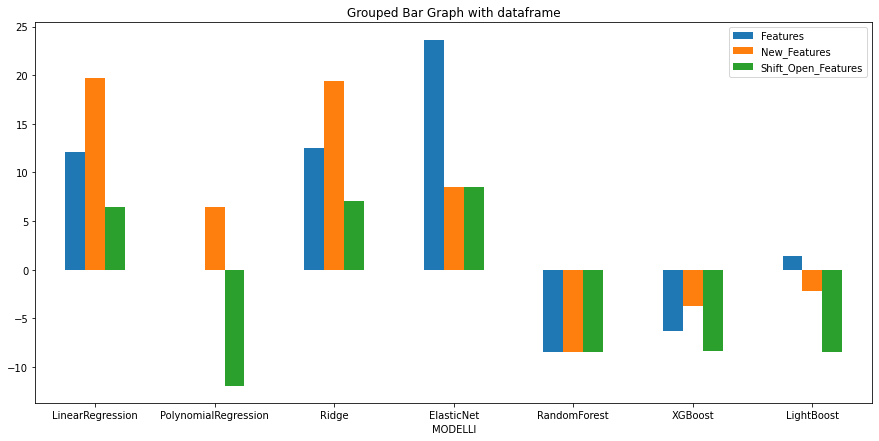

In [485]:
chartFromYear(2017)

Nel 2017, il modello più remunerativo è stato `ElasticNet`, con un ROI del 23.65%. In generale nel 2017 la regressione lineare è risultata molto performante.

## Risultati 2018

MODELLI                 Features    New_Features    Shift_Open_Features
--------------------  ----------  --------------  ---------------------
LinearRegression        30.2267         -2.0644                 8.40666
PolynomialRegression   -33.3656         -4.01236              -28.0529
Ridge                   23.7346         -2.0644                10.9343
ElasticNet               3.46193       -15.6634               -15.6634
RandomForest            15.5498         23.9109                10.2856
XGBoost                  2.15658       -21.5121               -15.9363
LightBoost               9.7546         -8.32388               15.155


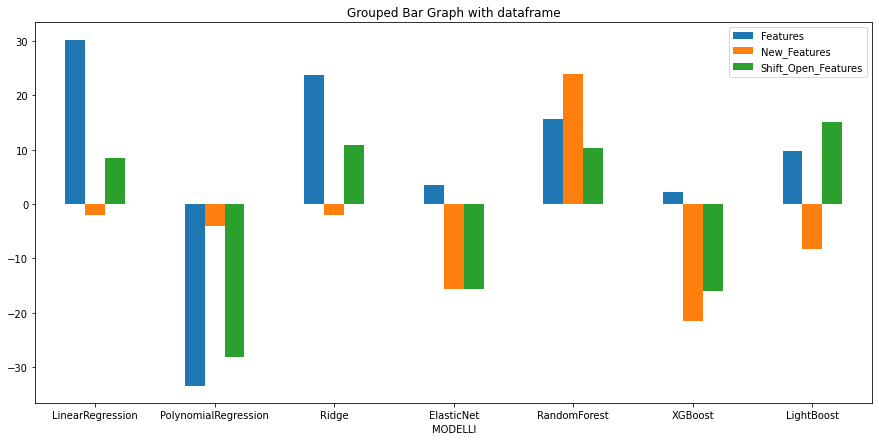

In [486]:
chartFromYear(2018)

Nel 2018 il modello migliore torna ad essere il `RandomForest` con un ROI del 23.42%.

## Risultati 2019

MODELLI                 Features    New_Features    Shift_Open_Features
--------------------  ----------  --------------  ---------------------
LinearRegression         1.83767        2.61874               -1.91486
PolynomialRegression    -7.53626       -8.06923                2.46002
Ridge                    1.31541        2.4418                -2.31914
ElasticNet             -15.5971        -9.60691              -16.5489
RandomForest           -10.2153        -0.225824               2.59157
XGBoost                  1.58691       10.8341                -9.98903
LightBoost              -8.09958       -6.38745               -0.185813


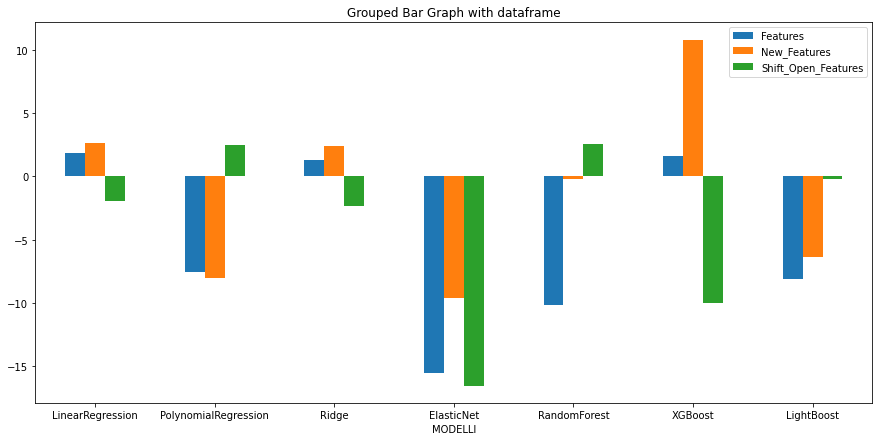

In [487]:
chartFromYear(2019)

Nel 2019, la nostra `rete neurale` riesce ad ottenere un ROI del 20.70%, seguito dalla `XGBoost` che totalizza il 10.83%.

## Risultati 2020

MODELLI                 Features    New_Features    Shift_Open_Features
--------------------  ----------  --------------  ---------------------
LinearRegression        -9.79944        18.6779                48.349
PolynomialRegression    28.6042          3.94705                7.80858
Ridge                  -11.7874         34.1158                48.349
ElasticNet              10.622          35.8173                14.4366
RandomForest            15.8998         11.597                 16.3598
XGBoost                 15.1356         40.2555                 6.18164
LightBoost               9.71081        45.1978                26.3585


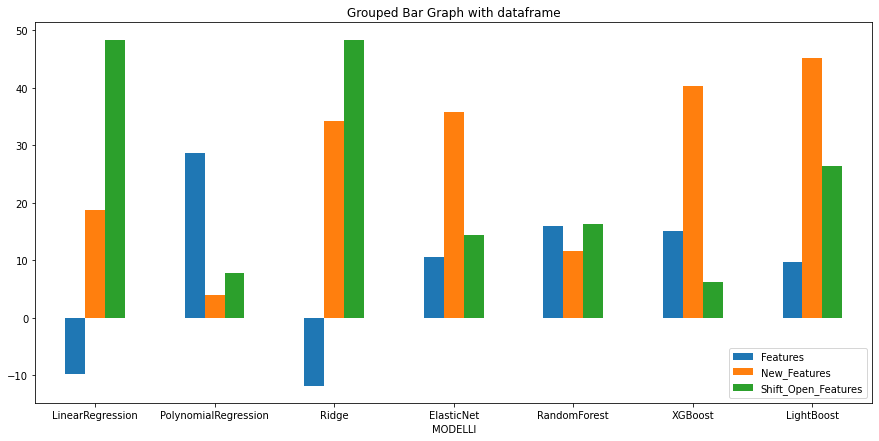

In [488]:
chartFromYear(2020)

Il 2020 è stato un anno particolarmente proficuo, tutti i modelli generano un guadagno molto alto, il migliore è il `LightBoost` con un guadagno del 45.19%.

## Risultati 2021

MODELLI                 Features    New_Features    Shift_Open_Features
--------------------  ----------  --------------  ---------------------
LinearRegression        -7.45338        9.50319                0.407208
PolynomialRegression    -4.74516       16.7656                -5.42596
Ridge                   -2.35116       10.0744                 0.723223
ElasticNet               8.97125       12.6279                 1.21674
RandomForest             5.98083       14.8164                -1.21674
XGBoost                 -2.92501        0.616308              -2.1516
LightBoost              15.7761        26.1103                 1.21674


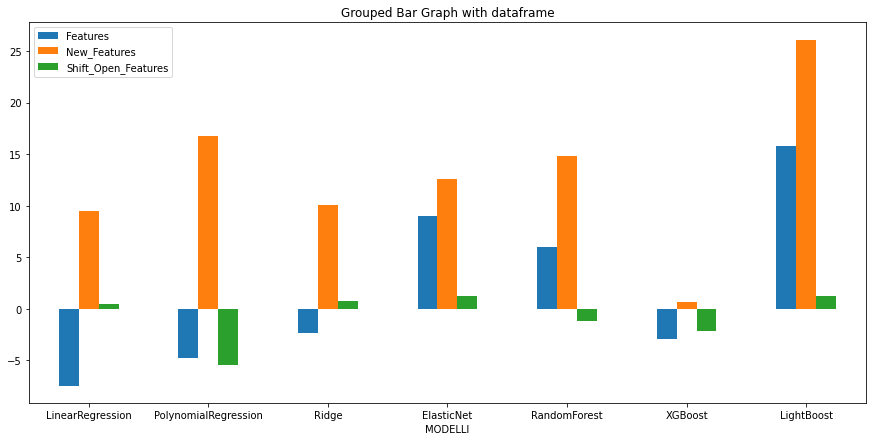

In [489]:
chartFromYear(2021)

Nel 2021, il modello più proficuo è lo stesso dell'anno precedente, ovvero `LightBoost` con un ROI del 26.11%